In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import merino.build_summary.expected_sensitivities as sense
import cmapPy.pandasGEXpress.parse as pe
import cmapPy.pandasGEXpress.subset_gctoo as sub
import cmapPy.pandasGEXpress.write_gctx as wgx
import cmapPy.pandasGEXpress.write_gct as wg
from statsmodels.distributions.empirical_distribution import ECDF
sns.set(font_scale=1.5)
sns.set_style("whitegrid")


# Benchmarking Different Data Processing Methods

We tested several different methods of data pre-processing, descriptions of each can be found in the processing lab notebook. The purpose of this notebook is to show a few ways of benchmarking different pre-processing methods, and to allow you to test your own methods of pre-processing against our standard process. 

In [2]:
BASE_PATH = os.path.expanduser('~/data/pfc')

In [3]:
proj_dir = os.path.join(BASE_PATH,'input/card/')

In [4]:
def mk_ds_list(proj_dir, input_type):
    filepaths = []
    group_ids = []
    
    search = proj_dir + '*/*{}.gct'.format(input_type)
    print proj_dir
    print search
    for path in glob.glob(search):
        new_path = os.path.join('input/card',os.path.basename(os.path.dirname(path)), os.path.basename(path)) 
        filepaths.append(new_path)
        group_ids.append(os.path.basename(os.path.dirname(path)).rsplit('_', 2)[0])
        
    ds_list = pd.DataFrame({'group_id': group_ids, 'file_path': filepaths})
    ds_list['file_path'] = ['/' + x for x in ds_list['file_path']]
    return ds_list

In [5]:
def plot_ecdf(values, ax, **kwargs):
    # equal weight for each observation, summing to 1
    weights = np.ones_like(values)/float(len(values))
    bins = sorted(values) + [np.inf]
    sns.distplot(values,
                 hist_kws={"cumulative": True,
                           "weights": weights,
                           "histtype": "step",
                           "alpha": 1,
                           "linewidth": 2},
                 bins=bins,
                 kde=False,
                 ax=ax,
                 **kwargs)
    
def fraction_recalled(df, threshold):
    return np.sum(df["median_recall_rank"] <= threshold) / len(df)

# Recall Analysis

## Method

The first metric that we use to benchmark different processing methods is replicate recall. We take the three biological replicates of a given plate of data, and we run a spearman correlation between the replicates. We then rank the score of that spearman correlation against the scores of all *non replicate correlations* on the plate. We consider a good recall result to be a signature that recalls in the top 5% of ranks

## Do it yourself!

If you have a new data processing method you can benchmark it using replicate recall. 

To do so, first take the raw level 2 data in input/assemble, and process it using your method. Output the resulting data files in the input/card folder following the plate naming conventions, and be sure to change the unique identifier in the file name (eg. change ZSPC to an identifier for your processing method). 


### Step 1: Create dataset list file
These cells are creating a table with paths to the data files that we will run recall on, and grouping them by their replicate sets. 
To do this for your own data processing, add a cell to this notebook like the ones directly below, call the mk_ds_list function and pass it your unique identifier (eg. mk_ds_list(proj_dir, 'ZSPC'), where proj_dir is the path to the card folder, and 'ZSPC' is the unique identifier.) Write this file out to the input folder. 

In [6]:
output_folders = ['output', 'output/zspc_recall', 'output/zsvc_recall', 'output/lfcpc_recall', 'output/lfcvc_recall']

[os.mkdir(x) for x in output_folders if not os.path.exists(x)]

[]

In [7]:
zspc_ds_list = mk_ds_list(proj_dir, 'ZSPC')
zspc_ds_list.to_csv(os.path.join('output/zspc_ds_list.txt'), sep='\t', index=False)

/home/jupyter-jasiedu/data/pfc/input/card/
/home/jupyter-jasiedu/data/pfc/input/card/*/*ZSPC.gct


In [8]:
zsvc_ds_list = mk_ds_list(proj_dir, 'ZSVC')
zsvc_ds_list.to_csv(os.path.join('output/zsvc_ds_list.txt'), sep='\t', index=False)

/home/jupyter-jasiedu/data/pfc/input/card/
/home/jupyter-jasiedu/data/pfc/input/card/*/*ZSVC.gct


In [9]:
lfcpc_ds_list = mk_ds_list(proj_dir, 'LFCPC')
lfcpc_ds_list.to_csv(os.path.join('output/lfcpc_ds_list.txt'), sep='\t', index=False)

/home/jupyter-jasiedu/data/pfc/input/card/
/home/jupyter-jasiedu/data/pfc/input/card/*/*LFCPC.gct


In [10]:
lfcvc_ds_list = mk_ds_list(proj_dir, 'LFCVC')
lfcvc_ds_list.to_csv(os.path.join('output/lfcvc_ds_list.txt'), sep='\t', index=False)

/home/jupyter-jasiedu/data/pfc/input/card/
/home/jupyter-jasiedu/data/pfc/input/card/*/*LFCVC.gct


### Step 2: Run sig recall tool

Now we are running the recall tool using the path to our ds_list file and an output folder. 

You can call sig_recall_tool using the cell starting with "%%capture sig_recall_output" as a template. Change the --ds_list argument to give the path to the ds_list file you just created, and change the --out argument to a new output folder that you create. Be sure to run the cell beginning with "cmd = "sudo service docker start"" to start the docker service before you run sig_recall. 

In [11]:
%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_recall_tool \
    --ds_list /output/zspc_ds_list.txt \
    --metric spearman \
    --sample_field pert_well \
    --out /output/zspc_recall \
    --create_subdir 0

### Step 3: Collate Results



Now we read in the results. Using the cell below as a template, construct the path to your outpur folder and read in all of the "recall_report_sets" files and concatenate them together. We will now repeat Steps 2-3 for each of our four data processing methods. Once these are ready we will plot the results and compare the four methods. 

In [12]:
recall_result_paths = glob.glob(os.path.join("output", "zspc_recall","*", "recall_report_sets.txt"))
zspc_recall_df = pd.concat([pd.read_csv(path, sep="\t", na_values="-666") for path in recall_result_paths])
zspc_recall_df["weave_prefix"] = zspc_recall_df["recall_group"].str.split(":").str[0]

In [13]:
zspc_recall_df.head()

,recall_group,recall_metric,col_pert_well,col_pert_id,col_pert_iname,col_pert_type,col_cell_id,col_pert_idose,col_pert_itime,col_pert_mfc_id,...,num_replicate,median_recall_score,median_recall_rank,median_recall_composite,median_max_rank,median_recall_col_rank,median_recall_row_rank,median_max_col_rank,median_max_row_rank,weave_prefix
0,PREP017:A01,spearman,A01,BRD-K60230970,MG-132,trt_poscon,NaN,20.00 uM,120 h,BRD-K60230970-001-14-2,...,3,0.571900,3.274320,0.743757,100,5.759160,1.061010,383,378,PREP017
1,PREP017:A02,spearman,A02,DMSO,DMSO,ctl_vehicle,NaN,NaN,120 h,NaN,...,3,0.306582,0.263158,0.552973,100,0.526316,0.000000,383,378,PREP017
2,PREP017:A03,spearman,A03,BRD-A05821830,DOCETAXEL,trt_cp,NaN,10.00 uM,120 h,BRD-A05821830-341-01-5,...,3,0.714349,0.530504,0.842947,100,0.000000,1.061010,383,378,PREP017
3,PREP017:A04,spearman,A04,BRD-A05821830,DOCETAXEL,trt_cp,NaN,0.62 uM,120 h,BRD-A05821830-341-01-5,...,3,0.727553,0.397878,0.851269,100,0.000000,0.795756,383,378,PREP017
4,PREP017:A05,spearman,A05,BRD-K35687421,Gimeracil,trt_cp,NaN,10.00 uM,120 h,BRD-K35687421-001-02-5,...,3,0.077257,10.755700,0.262579,100,12.827200,8.684210,383,378,PREP017


In [14]:
%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_recall_tool \
    --ds_list /output/zsvc_ds_list.txt \
    --metric spearman \
    --sample_field pert_well \
    --out /output/zsvc_recall \
    --create_subdir 0

In [15]:
recall_result_paths = glob.glob(os.path.join("output", "zsvc_recall","*", "recall_report_sets.txt"))
zsvc_recall_df = pd.concat([pd.read_csv(path, sep="\t", na_values="-666") for path in recall_result_paths])
zsvc_recall_df["weave_prefix"] = zsvc_recall_df["recall_group"].str.split(":").str[0]

In [16]:
zsvc_recall_df.head()

,recall_group,recall_metric,col_pert_well,col_pert_id,col_pert_iname,col_pert_type,col_cell_id,col_pert_idose,col_pert_itime,col_pert_mfc_id,...,num_replicate,median_recall_score,median_recall_rank,median_recall_composite,median_max_rank,median_recall_col_rank,median_recall_row_rank,median_max_col_rank,median_max_row_rank,weave_prefix
0,PREP017:A01,spearman,A01,BRD-K60230970,MG-132,trt_poscon,NaN,20.00 uM,120 h,BRD-K60230970-001-14-2,...,3,0.484738,3.408650,0.684263,100,4.71204,2.105260,383,378,PREP017
1,PREP017:A02,spearman,A02,DMSO,DMSO,ctl_vehicle,NaN,NaN,120 h,NaN,...,3,0.198233,0.523560,0.444067,100,1.04712,0.530504,383,378,PREP017
2,PREP017:A03,spearman,A03,BRD-A05821830,DOCETAXEL,trt_cp,NaN,10.00 uM,120 h,BRD-A05821830-341-01-5,...,3,0.651820,0.927335,0.803601,100,1.04712,1.326260,383,378,PREP017
3,PREP017:A04,spearman,A04,BRD-A05821830,DOCETAXEL,trt_cp,NaN,0.62 uM,120 h,BRD-A05821830-341-01-5,...,3,0.642084,0.526316,0.794166,100,0.00000,1.052630,383,378,PREP017
4,PREP017:A05,spearman,A05,BRD-K35687421,Gimeracil,trt_cp,NaN,10.00 uM,120 h,BRD-K35687421-001-02-5,...,3,0.093260,21.114300,0.271236,100,15.96860,26.259900,383,378,PREP017


In [17]:
%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_recall_tool \
    --ds_list /output/lfcpc_ds_list.txt \
    --metric spearman \
    --sample_field pert_well \
    --out /output/lfcpc_recall \
    --create_subdir 0

In [18]:
recall_result_paths = glob.glob(os.path.join("output", "lfcpc_recall","*", "recall_report_sets.txt"))
lfcpc_recall_df = pd.concat([pd.read_csv(path, sep="\t", na_values="-666") for path in recall_result_paths])
lfcpc_recall_df["weave_prefix"] = lfcpc_recall_df["recall_group"].str.split(":").str[0]

In [19]:
lfcpc_recall_df.head()

,recall_group,recall_metric,col_pert_well,col_pert_id,col_pert_iname,col_pert_type,col_cell_id,col_pert_idose,col_pert_itime,col_pert_mfc_id,...,num_replicate,median_recall_score,median_recall_rank,median_recall_composite,median_max_rank,median_recall_col_rank,median_recall_row_rank,median_max_col_rank,median_max_row_rank,weave_prefix
0,PREP017:A01,spearman,A01,BRD-K60230970,MG-132,trt_poscon,NaN,20.00 uM,120 h,BRD-K60230970-001-14-2,...,3,0.257579,3.955740,0.497383,100,5.789470,2.368420,383,378,PREP017
1,PREP017:A02,spearman,A02,DMSO,DMSO,ctl_vehicle,NaN,NaN,120 h,NaN,...,3,0.298941,0.131579,0.543885,100,0.263158,0.000000,383,378,PREP017
2,PREP017:A03,spearman,A03,BRD-A05821830,DOCETAXEL,trt_cp,NaN,10.00 uM,120 h,BRD-A05821830-341-01-5,...,3,0.681689,0.132626,0.825097,100,0.000000,0.265252,383,378,PREP017
3,PREP017:A04,spearman,A04,BRD-A05821830,DOCETAXEL,trt_cp,NaN,0.62 uM,120 h,BRD-A05821830-341-01-5,...,3,0.689431,0.394048,0.830320,100,0.261780,0.526316,383,378,PREP017
4,PREP017:A05,spearman,A05,BRD-K35687421,Gimeracil,trt_cp,NaN,10.00 uM,120 h,BRD-K35687421-001-02-5,...,3,0.087259,7.605400,0.283942,100,9.947640,5.263160,383,378,PREP017


In [20]:
%%capture sig_recall_output
! udocker run --rm \
    -v ~/data/pfc/input:/input \
    -v ~/data/pfc/vdb:/cmap/data/vdb \
    -v $PWD/output:/output \
    cmap/sig_recall_tool \
    --ds_list /output/lfcvc_ds_list.txt \
    --metric spearman \
    --sample_field pert_well \
    --out /output/lfcvc_recall \
    --create_subdir 0

In [21]:
recall_result_paths = glob.glob(os.path.join("output", "lfcvc_recall","*", "recall_report_sets.txt"))
lfcvc_recall_df = pd.concat([pd.read_csv(path, sep="\t", na_values="-666") for path in recall_result_paths])
lfcvc_recall_df["weave_prefix"] = lfcvc_recall_df["recall_group"].str.split(":").str[0]

In [22]:
lfcvc_recall_df.head()

,recall_group,recall_metric,col_pert_well,col_pert_id,col_pert_iname,col_pert_type,col_cell_id,col_pert_idose,col_pert_itime,col_pert_mfc_id,...,num_replicate,median_recall_score,median_recall_rank,median_recall_composite,median_max_rank,median_recall_col_rank,median_recall_row_rank,median_max_col_rank,median_max_row_rank,weave_prefix
0,PREP017:A01,spearman,A01,BRD-K60230970,MG-132,trt_poscon,NaN,20.00 uM,120 h,BRD-K60230970-001-14-2,...,3,0.267875,3.166270,0.509307,100,4.21053,2.368420,383,378,PREP017
1,PREP017:A02,spearman,A02,DMSO,DMSO,ctl_vehicle,NaN,NaN,120 h,NaN,...,3,0.184506,0.786029,0.427287,100,1.30890,0.000000,383,378,PREP017
2,PREP017:A03,spearman,A03,BRD-A05821830,DOCETAXEL,trt_cp,NaN,10.00 uM,120 h,BRD-A05821830-341-01-5,...,3,0.674749,0.132626,0.820886,100,0.00000,0.265252,383,378,PREP017
3,PREP017:A04,spearman,A04,BRD-A05821830,DOCETAXEL,trt_cp,NaN,0.62 uM,120 h,BRD-A05821830-341-01-5,...,3,0.678616,0.394048,0.823782,100,0.26178,0.526316,383,378,PREP017
4,PREP017:A05,spearman,A05,BRD-K35687421,Gimeracil,trt_cp,NaN,10.00 uM,120 h,BRD-K35687421-001-02-5,...,3,0.080777,25.998900,0.231276,100,20.41880,31.578900,383,378,PREP017


### Step 4: Plotting and benchmarking

Here we plot an ECDF of recall ranks by signature for each data pre-processing method. We also display the percentage of signatures which pass our recall rank threshold of 5%. Here we find that Log Fold Change Plate Control performs the best by a slim margin, with plate control methods performing considerably better than vehicle control. To add your own data processing method to the plot, simply add its collated recall table to the dictionary "recall_dict" in the cell below.

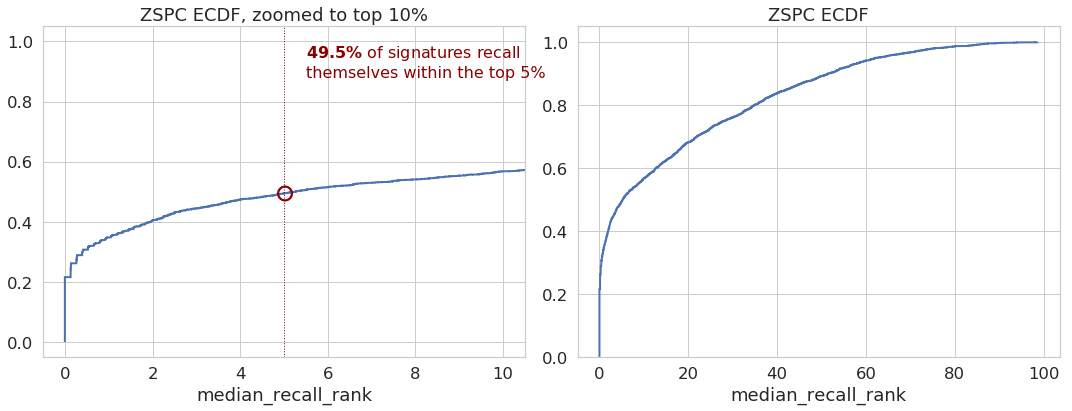

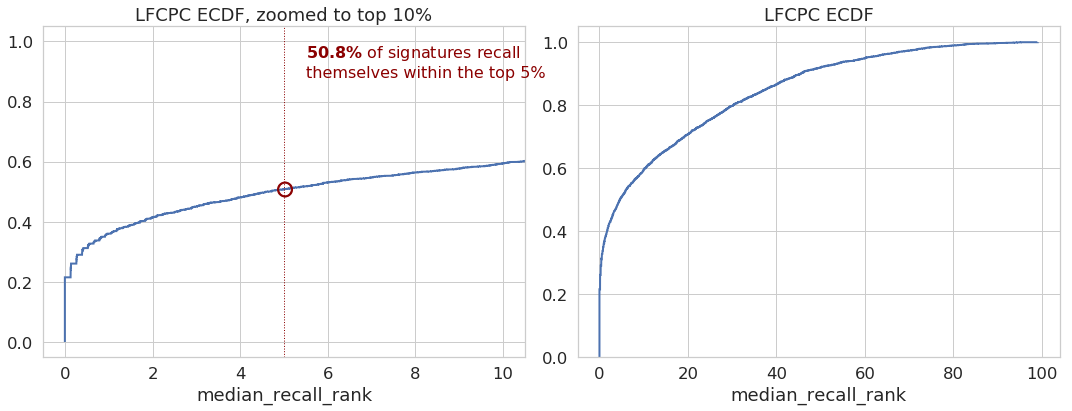

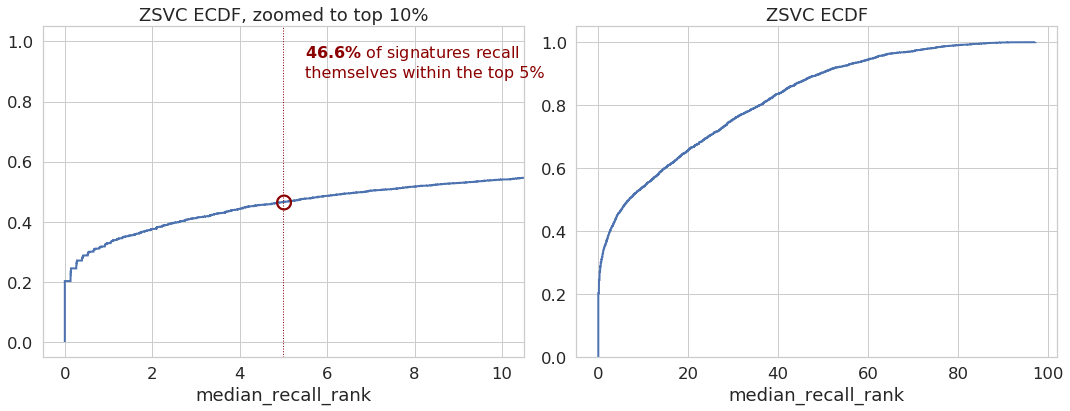

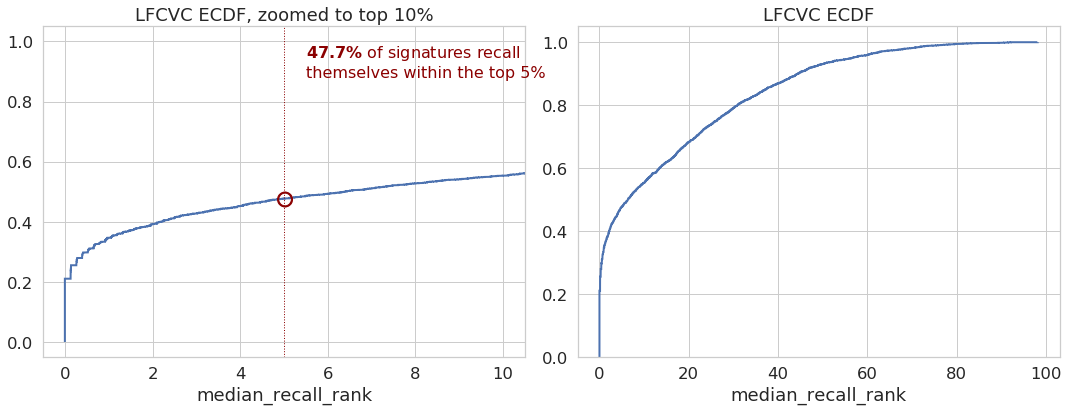

In [23]:
recall_dict = {'ZSPC': zspc_recall_df, 'ZSVC': zsvc_recall_df, 'LFCPC': lfcpc_recall_df, 'LFCVC': lfcvc_recall_df}

for key in recall_dict:
    recall_df = recall_dict[key]
    f, ax = plt.subplots(1, 2, figsize=(15,6)) 

    plot_ecdf(recall_df["median_recall_rank"], ax[0])
    ax[0].set_xlim(-0.5, 10.5)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].set_title("{} ECDF, zoomed to top 10%".format(key))

    recall_top5_pct = np.sum(recall_df["median_recall_rank"] <= 5) / len(recall_df) * 100
    ax[0].axvline(5, linestyle="dotted", linewidth=1, color="darkred")
    ax[0].text(5.5, 1,
               (r"$\bf{0:.1f}\%$".format(recall_top5_pct) +
                " of signatures recall\nthemselves within the top 5%"),
               verticalalignment="top",
               fontsize=16,
               color="darkred")
    ax[0].plot(5, recall_top5_pct/100, marker=r'$\bigcirc$', markersize=16, color="darkred")

    plot_ecdf(recall_df["median_recall_rank"], ax[1])
    ax[1].set_title("{} ECDF".format(key))

    f.tight_layout(rect=(0,.03,1,1))
    plt.show()

In [24]:
zspc_pct_recovery = zspc_recall_df[zspc_recall_df['median_recall_rank'] < 5].shape[0] / zspc_recall_df.shape[0]
zsvc_pct_recovery = zsvc_recall_df[zsvc_recall_df['median_recall_rank'] < 5].shape[0] / zsvc_recall_df.shape[0]
lfcpc_pct_recovery = lfcpc_recall_df[lfcpc_recall_df['median_recall_rank'] < 5].shape[0] / lfcpc_recall_df.shape[0]
lfcvc_pct_recovery = lfcvc_recall_df[lfcvc_recall_df['median_recall_rank'] < 5].shape[0] / lfcvc_recall_df.shape[0]

In [25]:
pd.DataFrame({'ZSPC': zspc_pct_recovery, 'ZSVC': zsvc_pct_recovery, 'LFCPC':  lfcpc_pct_recovery, 'LFCVC': lfcvc_pct_recovery}, index=['pct_sigs_recovered']).T

,pct_sigs_recovered
LFCPC,0.508325
LFCVC,0.477310
ZSPC,0.494613
ZSVC,0.465557


# Expected Sensitivities

## Method

Our second metric for benchmarking data is expected sensitivities. We have compounds with sets of known sensitive cell lines, and we run a weighted connectivoty score analysis using those cell lines as the query set to see how well they pick up their expected sensitivities. For this we are using our PASG dataset rather than PREP, as PASG has many compounds with known sensitivities. 


For producing this with your own data you will need a concatenated "build file" of all your level 4 or level 5 plate files. You can concatenate GCToos together using cmapPy.pandasGEXpress.concat. Use its "hstack" function to produce your build file. You can use the existing metadata files. 

### Step 1: Read in the data

Read in the concatenated data file that you produced

In [26]:
inst_info = pd.read_table(os.path.join(BASE_PATH,'input/pasg_build/PASG003_inst_info.txt'), index_col='profile_id')

zspc_data = pe.parse(os.path.join(BASE_PATH,'input/pasg_build/PASG003_LEVEL4_ZSPC_n1119x489.gctx'))
zsvc_data = pe.parse(os.path.join(BASE_PATH,'input/pasg_build/PASG003_LEVEL4_ZSVC_n1119x489.gctx'))
lfcpc_data = pe.parse(os.path.join(BASE_PATH,'input/pasg_build/PASG003_LEVEL4_LFCPC_n1119x489.gctx'))
lfcvc_data = pe.parse(os.path.join(BASE_PATH,'input/pasg_build/PASG003_LEVEL4_LFCVC_n1119x489.gctx'))

### Step 2: Run expected sensitivities

Feed the sense.wtks method to your data file, and a new output folder that you create.

In [27]:
if not os.path.isdir("output/zspc_sensitivities"):
    os.makedirs("output/zspc_sensitivities")
    
if not os.path.isdir("output/zsvc_sensitivities"):
    os.makedirs("output/zsvc_sensitivities")  
    
if not os.path.isdir("output/lfcvc_sensitivities"):
    os.makedirs("output/lfcvc_sensitivities")  
    
if not os.path.isdir("output/lfcpc_sensitivities"):
    os.makedirs("output/lfcpc_sensitivities") 

In [28]:
sense.wtks(gct=zspc_data, metadata=inst_info, gmt_path=os.path.join(BASE_PATH,'vdb/PRISM/sensitivity_files/full_sensitivities.gmt'), outfolder='output/zspc_sensitivities',group_col='prism_replicate')

In [29]:
sense.wtks(gct=zsvc_data, metadata=inst_info, outfolder='output/zsvc_sensitivities',gmt_path=os.path.join(BASE_PATH,'vdb/PRISM/sensitivity_files/full_sensitivities.gmt'),group_col='prism_replicate')

In [30]:
sense.wtks(gct=lfcpc_data, metadata=inst_info, outfolder='output/lfcpc_sensitivities/',gmt_path=os.path.join(BASE_PATH,'vdb/PRISM/sensitivity_files/full_sensitivities.gmt'),group_col='prism_replicate')

In [31]:
sense.wtks(gct=lfcvc_data, metadata=inst_info, outfolder='output/lfcvc_sensitivities/',gmt_path=os.path.join(BASE_PATH,'vdb/PRISM/sensitivity_files/full_sensitivities.gmt'),group_col='prism_replicate')

### Step 3: Read in the results file

In your output folder there will be a file called expected_sensitivity_ranks.txt. Read this in. 

In [32]:
zspc_sense = pd.read_table('output/zspc_sensitivities/expected_sensitivity_ranks.txt', index_col='det_plate')
zsvc_sense = pd.read_table('output/zsvc_sensitivities/expected_sensitivity_ranks.txt', index_col='det_plate')
lfcpc_sense = pd.read_table('output/lfcpc_sensitivities/expected_sensitivity_ranks.txt', index_col='det_plate')
lfcvc_sense = pd.read_table('output/lfcvc_sensitivities/expected_sensitivity_ranks.txt', index_col='det_plate')

### Step 4: Convert ranks to percentile

The ranks in the output file range from 1-384, as each signature is ranked against each other on a 384 well plate. Here we convert the ranks to a percentile to keep in line with the previous recall analysis

In [33]:
zspc_sense_pct = (zspc_sense / 384) * 100
zsvc_sense_pct = (zsvc_sense / 384) * 100
lfcpc_sense_pct = (lfcpc_sense / 384) * 100
lfcvc_sense_pct = (lfcvc_sense / 384) * 100

### Step 5: Plot result and benchmark

We use the same ECDF plotting function that we used for recall to display these results. Once again, simply add your results file to the dictionary to plot its result. In the case of expected sensitivities, we found that ZSPC performed the best recovering 51% of compounds at our 5% rank threshold. 

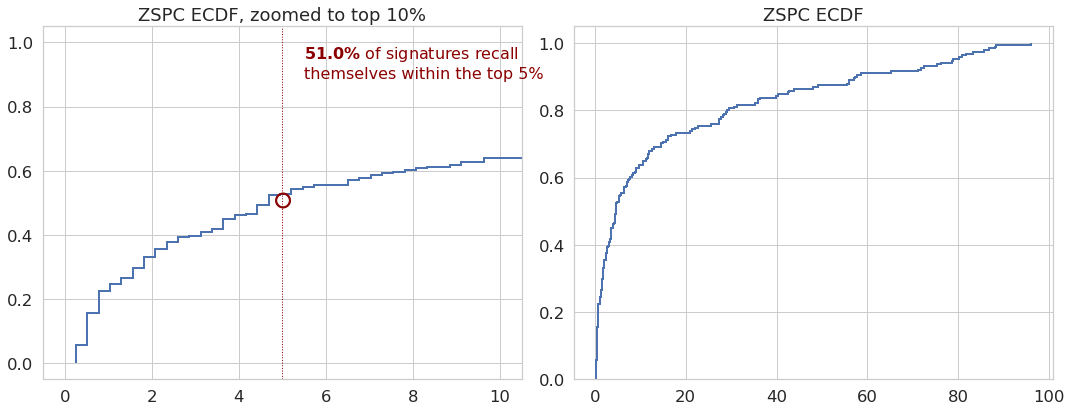

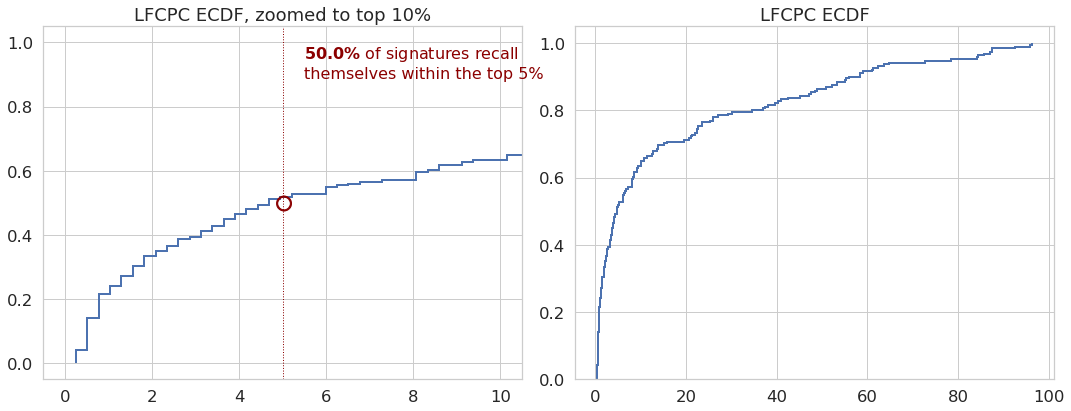

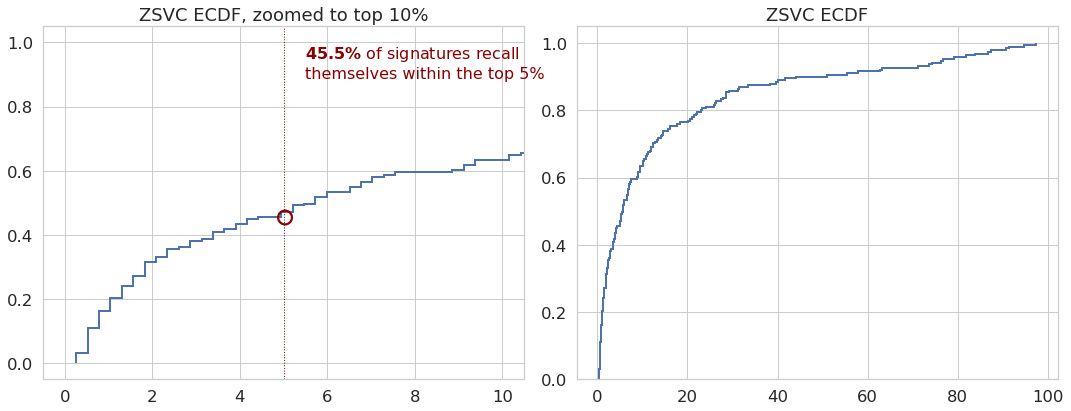

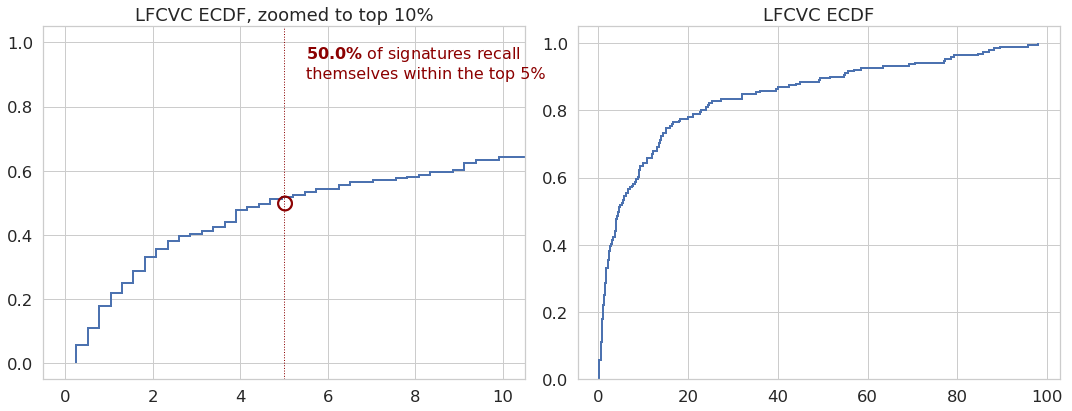

In [34]:
sense_dict = {'ZSPC': zspc_sense_pct, 'ZSVC': zsvc_sense_pct, 'LFCPC': lfcpc_sense_pct, 'LFCVC': lfcvc_sense_pct}

for key in sense_dict:
    sense_df = sense_dict[key]
    f, ax = plt.subplots(1, 2, figsize=(15,6)) 

    plot_ecdf(sense_df.unstack().dropna(), ax[0])
    ax[0].set_xlim(-0.5, 10.5)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].set_title("{} ECDF, zoomed to top 10%".format(key))

    recall_top5_pct = np.sum(sense_df.unstack() <= 5) / len(sense_df.unstack()) * 100
    ax[0].axvline(5, linestyle="dotted", linewidth=1, color="darkred")
    ax[0].text(5.5, 1,
               (r"$\bf{0:.1f}\%$".format(recall_top5_pct) +
                " of signatures recall\nthemselves within the top 5%"),
               verticalalignment="top",
               fontsize=16,
               color="darkred")
    ax[0].plot(5, recall_top5_pct/100, marker=r'$\bigcirc$', markersize=16, color="darkred")

    plot_ecdf(sense_df.unstack().dropna(), ax[1])
    ax[1].set_title("{} ECDF".format(key))

    f.tight_layout(rect=(0,.03,1,1))
    plt.show()